# Notebook 6: Ligand Binding, Conformational change and Linear Response theory

### Modeling ligand binding in the elastic network.

In this work shop we want to define a notion of allostery in our elastic networks. Before we do that we must defined what it means for elastic networks to bind ligand. In proteins, ligand binding acts as a perturbation at the binding sites. In our model we will represent the effect of ligand binding as an imposed displacement on few nodes on the exterior of the network, as shown below.


&nbsp;

<p align="center">
  <img src="./figures/network_strain_at_binding_site.svg" alt="drawing" width="300"/>
</p>


Once this is done we need to compute the response of the rest of the network to the applied displacement. How does the rest of the network move? To do this we will need to do a linear response calculation.

In linear response, the force $F$ on each node that results from a displacement $\Delta r$ is given by,

$$F = H \Delta r$$



We are going to apply a displacement on a group of nodes (call them the binding site nodes) but leave the others to respond. Our linear response problem looks like this now,

$$ 
 \left(\begin{matrix}
f_a \\
0 \\
\end{matrix}\right)
 = H 

\left(\begin{matrix}
\Delta r_a \\
\Delta r_r \\
\end{matrix}\right)
$$

Where $\Delta r_a$ is the diplacment we apply on the binding site nodes, $f_a$ is the resulting force on the binding site nodes, and  $\Delta r_r$ is the response displacement on the rest of the network. The subscript $a$ represents the inidices that cooresponds to the binding site and the subscript $r$ represents the inidices that cooresponds to the rest of the network. We are not constraining the nodes outside the binding site so we know the force on them is zero because they are at mechanical equilibrium. The variables we need to solve for are $\Delta r_r$ and $f_c$.

In order to solve matrix equation on the computer we need to get it in the form of,

$$ Ax=b $$

where $A$ is a matrix, $x$ is the unknown vector and $b$ is the known vector. This can be done, as follows,

$$ B 

\left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)
= H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)
$$

with,

$$ B_{ij} = 
\bigg\{\begin{matrix}
\delta_{ij},  &  \text{if} \ j \in a\\
-H_{ij}, &  \text{if} \ j \notin a\\
\end{matrix}
$$


To compute the energy that results from an applied strain, we take the dot product between the force and displacement,

$$ E = \

\left(\begin{matrix}
f_a \\
0 \\
\end{matrix}\right)
\cdot
\left(\begin{matrix}
\Delta r_a \\
\Delta r_r \\
\end{matrix}\right)
$$

In [3]:
using Revise, LinearAlgebra, PyPlot, LaTeXStrings
push!(LOAD_PATH, "./src/")
using Elastic_N3, Elastic_N4, Elastic_N5

In [262]:
# Build network

W = 10 # width of network
L = 10 # length of network
q = 5 # number of node types
disorder = 0.1 # spatial disorder added to structure
k_min = 1e1 # softest spring constant in interaction table
k_max = 1e-2 # stiffest spring constant in interaction table

# build our network components
r, A = buildStructure(W, L, disorder)
seq = rand(1:q, W*L)
K = buildSpringTable(q, k_min, k_max)
S = seq2Springs(seq, K, A);
H = computeHessian(r, S);

First lets pick some nodes to apply a displacment to.

In [263]:
bindingSiteNodes = [4,5,6,7]

4-element Vector{Int64}:
 4
 5
 6
 7

In [264]:
# get the idicies that correspond to  these nodes in the structure vector
site = sort([bindingSiteNodes * 2; bindingSiteNodes * 2 .- 1])

8-element Vector{Int64}:
  7
  8
  9
 10
 11
 12
 13
 14

Next, Let's generated a random diplament and normalize it.

In [265]:
strain = randn(2 * length(bindingSiteNodes))
normalize!(strain)

8-element Vector{Float64}:
 -0.5768264073799535
  0.3432715231636951
  0.09654991854434691
 -0.3129690339295324
  0.4169110977300459
  0.4643846553410608
 -0.09115637498247822
 -0.21068222026942357

In [266]:
# check to see if it has unit length.
norm(strain)

1.0

In [267]:
dr = zeros(size(r))
dr[site] .= strain;

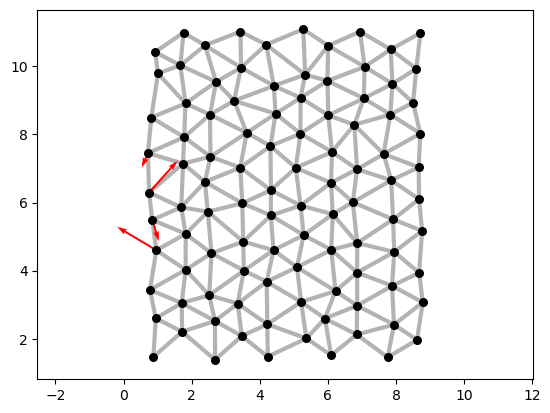

In [268]:
# plot applied displacement on binding site nodes.
fig, ax = subplots()
plotNetwork!(ax,r, A)
plotDisplacment!(ax, r, dr)
fig.savefig("network_strain_at_binding_site.svg")

## Setting up the linear response calculation

#### 1: Make the vector

$$
c = \left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)
$$

In [269]:
c = zeros(length(r))
c[site] = strain
c

200-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.5768264073799535
  0.3432715231636951
  0.09654991854434691
 -0.3129690339295324
  0.4169110977300459
  0.4643846553410608
 -0.09115637498247822
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

#### 2. Compute Matrix multiplication

$$
b = H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right) = H c
$$


In [270]:
b = H * c


#### 3: Build $B$

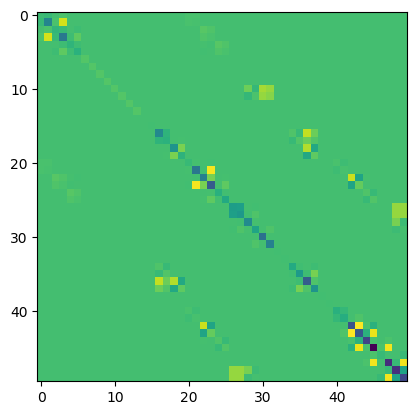

PyObject <matplotlib.image.AxesImage object at 0x7fa1e9ae2550>

In [271]:
B = -H
B[:,site] = I(size(B,1))[:,site]
imshow(B[1:50, 1:50])


#### 4: Solve the linear problem
$$ x = \left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)$$

$$ B x = b $$ 

In [272]:
# use the all powerful matrix div opporator: \
x = B \ b 

200-element Vector{Float64}:
 -0.1526136518438953
  0.033174761240295315
 -0.11451319974312481
  0.030801305010718115
 -0.0862152222459161
  0.036563763178923396
 -0.0023282468732236587
  0.0035861746861001356
 -0.0006701250952697766
 -0.0052893250066471074
  0.0029651826464521342
  0.12789046189296654
  3.318932204037974e-5
  ⋮
  0.010745657069812273
 -0.23054120081344293
  0.03976445942423033
 -0.2302416876416986
  0.07404430617791237
 -0.23277915262738422
  0.10152367218681844
 -0.223416066777186
  0.12532513075048074
 -0.2252842568901932
  0.15439361292434328
 -0.22861789815375594

#### 5: Make the force and displacement vectors, 

$$ 
F =  \left(\begin{matrix}
f_a \\
0 \\
\end{matrix}\right)
\quad \text{and} \quad
\Delta r = \left(\begin{matrix}
\Delta r_a \\
\Delta r_r \\
\end{matrix}\right)
$$

In [273]:
# compute the force vector on all nodes
F = copy(c)
F[site] = x[site]
F

200-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.0023282468732236587
  0.0035861746861001356
 -0.0006701250952697766
 -0.0052893250066471074
  0.0029651826464521342
  0.12789046189296654
  3.318932204037974e-5
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [276]:
# compute diplacement vector of all nodes
Δr = copy(x)
Δr[site] = c[site]
Δr

200-element Vector{Float64}:
 -0.1526136518438953
  0.033174761240295315
 -0.11451319974312481
  0.030801305010718115
 -0.0862152222459161
  0.036563763178923396
 -0.5768264073799535
  0.3432715231636951
  0.09654991854434691
 -0.3129690339295324
  0.4169110977300459
  0.4643846553410608
 -0.09115637498247822
  ⋮
  0.010745657069812273
 -0.23054120081344293
  0.03976445942423033
 -0.2302416876416986
  0.07404430617791237
 -0.23277915262738422
  0.10152367218681844
 -0.223416066777186
  0.12532513075048074
 -0.2252842568901932
  0.15439361292434328
 -0.22861789815375594

#### 6: Compute the energy of "ligand Binding"

$$ E = F \cdot \Delta r$$

In [277]:
E = dot(F, Δr)

0.0913737035136089

#### 7: Wrap it all up into function

In [280]:
function computeResponse(r, H, strain, site)
    # Solve the linear response problem.

    # build vector (Δr_a, 0)
    c = zeros(length(r))
    c[site] = strain

    # multiply 
    b = H * c
    removeTranslationRotation!(b, r)

    # build B matrix
    B = -H
    B[:,site] = I(size(B,1))[:,site]

    # solve linear problem
    x = B \ b 

    # get Force vector
    F = copy(c)
    F[site] = x[site]

    # get displacement vector
    Δr = copy(x)
    Δr[site] = c[site]

    # compute Energy
    E = dot(F, Δr)

    return E, F, Δr 
end

computeResponse (generic function with 1 method)

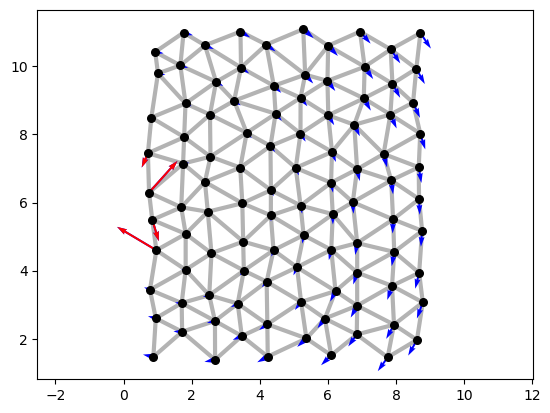

In [281]:
# show response on network
E, F, Δr  = computeResponse(r, H, strain, site);

fig, ax = subplots()
plotNetwork!(ax,r, A)

# plot response
plotDisplacment!(ax,r, Δr, color="b")

# plot applied displacement
plotDisplacment!(ax,r, dr, color="r")

It looks like we are seeing a lot of rotation and we can't see the under lying deformation. Let's remove the rotation and translation. Here are two functions to do this.

In [210]:
function getTranslationRotation(r)
    
    # r is a vector of positions r = (x1,y1,x2,y2,...)
    N = length(r)
    @assert iseven(N)
    n = Int(N/2)
    
    # move origin to center of mass
    xy = r2xy(r)
    x_mean, y_mean = mean(xy, dims=1)
    xy[:,1] .-= x_mean
    xy[:,2] .-= y_mean
    r = xy2r(xy)

    # compute x and y translations vector
    vx = normalize([ones(n) zeros(n)]'[:])
    vy = normalize([zeros(n) ones(n)]'[:])
    
    # compute rotation vector
    rotMat = [0 -1; 1 0]
    R = zeros(N, N)
    for i in 1:n
        R[2i-1:2i,2i-1:2i] = rotMat
    end
    vr = normalize(R * r)
    return [vx vy vr]
end

function removeTranslationRotation!(dr, r)
    # dr : applied displacement
    # r : postion vector

    V = getTranslationRotation(r)
    dr .-= V * V' * dr
    normalize!(dr)
    return nothing
end


removeTranslationRotation! (generic function with 1 method)

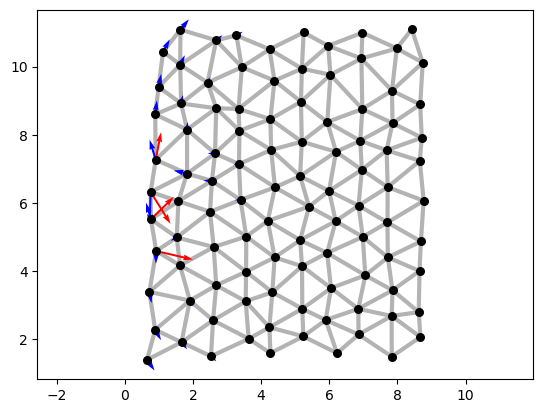

In [211]:
removeTranslationRotation!(Δr, r)

fig, ax = subplots()
plotNetwork!(ax,r, A)

# plot response
plotDisplacment!(ax,r, Δr, color="b", scale=0.5)

# # plot applied displacement
plotDisplacment!(ax,r, dr, color="r")


In [282]:
W = 10 # width of network
L = 10 # length of network
q = 5 # number of node types
disorder = 0.1 # spatial disorder added to structure
k_min = 1e1 # softest spring constant in interaction table
k_max = 1e-2 # stiffest spring constant in interaction table

# build our network components
r, A = buildStructure(W, L, disorder)
seq = rand(1:q, W*L)
K = buildSpringTable(q, k_min, k_max)
S = seq2Springs(seq, K, A);
H = computeHessian(r, S);

In [283]:
bindingSiteNodes = [4,5,6,7]

site = sort([bindingSiteNodes * 2; bindingSiteNodes * 2 .- 1])
strain = randn(2 * length(bindingSiteNodes))
removeTranslationRotation!(strain, r[site])
normalize!(strain)

dr = zeros(size(r))
dr[site] .= strain;

In [284]:
site

8-element Vector{Int64}:
  7
  8
  9
 10
 11
 12
 13
 14

In [285]:
f = H * dr
sum(f)

-8.215650382226158e-15

In [286]:
collect(7:2:13)

4-element Vector{Int64}:
  7
  9
 11
 13

In [287]:
dr = zeros(size(r))
dr[site] .= strain;

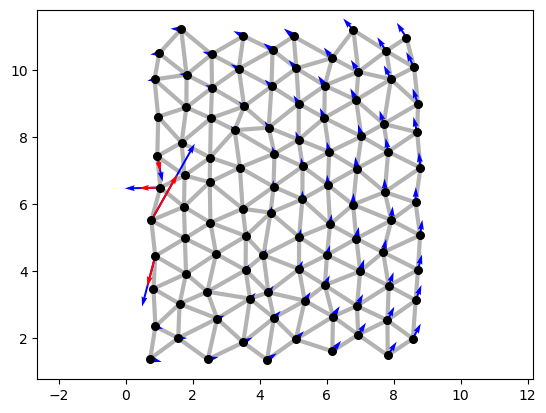

In [292]:
E, F, Δr  = computeResponse(r, H, strain, site);

#removeTranslationRotation!(Δr, r)

fig, ax = subplots()
plotNetwork!(ax,r, A)

# plot response
plotDisplacment!(ax,r, Δr, color="b", scale=0.3)

# # plot applied displacement
plotDisplacment!(ax,r, dr, color="r")

In [145]:
norm(Δr)

3.7402127405860446

In [146]:
removeTranslationRotation!(Δr, r)
norm(Δr)

1.0